# RNN Monte Carlo
Author: Daniel Carne

Date: 6/25/2024

Description: Reccurent neural network to model multi-layer media trained on Monte Carlo simulations.

In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import time

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load in data and seperate inputs and answers

In [14]:
dataset_a = np.loadtxt('/content/drive/My Drive/Colab Notebooks/RNN_Monte_Carlo/D1.2_compileda.txt')
dataset_b = np.loadtxt('/content/drive/My Drive/Colab Notebooks/RNN_Monte_Carlo/D1.2_compiledb.txt')
dataset = np.concatenate((dataset_a, dataset_b), axis=0)
input_t = np.zeros((len(dataset[:, 0]), 4))
input_t[:, :] = dataset[:, :4]
# dimensionless mu_a*t and mu_s*t
input_t[:, 1] *= dataset[:, 4]
input_t[:, 2] *= dataset[:, 4]
answers_t = np.zeros((len(dataset[:, 0]), 3))
answers_t[:, 0] = dataset[:, 6] + dataset[:, 7]
answers_t[:, 1] = dataset[:, 8]
answers_t[:, 2] = dataset[:, 9]

 Normalize inputs (improve this in future)

In [15]:
# normalize inputs
input_t2 = input_t.copy()
# refractive index and asymmetry parameter linear norm
input_t2[:, 0] = input_t[:, 0]/2.5
input_t2[:, 3] = input_t[:, 3]
# mu_s*t and mu_a*t logrithmic norm
input_t2[:, 1] = np.log10(input_t[:, 1]+0.0001)
input_t2[:, 1] += 4
input_t2[:, 1] /= 8.69154
input_t2[:, 2] = np.log10(input_t[:, 2]+0.0001)
input_t2[:, 2] += 4
input_t2[:, 2] /= 8.69549
input_t2[:, 3] = -((-input_t2[:, 3]+1)**(1/3))+1

Organize training and test data into 4 sets of tensors by number of layers

In [16]:
input_1l = np.zeros((0, 4))
input_2l = np.zeros((0, 4))
input_3l = np.zeros((0, 4))
input_4l = np.zeros((0, 4))
answers_1l = np.zeros((0, 3))
answers_2l = np.zeros((0, 3))
answers_3l = np.zeros((0, 3))
answers_4l = np.zeros((0, 3))

for i in range(int(len(input_t2[:, 0])/6)):
  index = i*6
  # get num layers then organize
  if input_t2[index+1, 0] == 0:
    input_1l = np.vstack((input_1l, input_t2[index, :]))
    answers_1l = np.vstack((answers_1l, answers_t[index, :]))
  elif input_t2[index+2, 0] == 0:
    input_2l = np.vstack((input_2l, input_t2[index:index+2, :]))
    answers_2l = np.vstack((answers_2l, answers_t[index, :]))
  elif input_t2[index+3, 0] == 0:
    input_3l = np.vstack((input_3l, input_t2[index:index+3, :]))
    answers_3l = np.vstack((answers_3l, answers_t[index, :]))
  else:
    input_4l = np.vstack((input_4l, input_t2[index:index+4, :]))
    answers_4l = np.vstack((answers_4l, answers_t[index, :]))
# move over to tensor
input_1l = torch.from_numpy(input_1l.astype(np.float32))
input_2l = torch.from_numpy(input_2l.astype(np.float32))
input_3l = torch.from_numpy(input_3l.astype(np.float32))
input_4l = torch.from_numpy(input_4l.astype(np.float32))
answers_1l = torch.from_numpy(answers_1l.astype(np.float32))
answers_2l = torch.from_numpy(answers_2l.astype(np.float32))
answers_3l = torch.from_numpy(answers_3l.astype(np.float32))
answers_4l = torch.from_numpy(answers_4l.astype(np.float32))
# create input tensors (num layers, batch size, num inputs)
input_tensor_1l = torch.zeros(1, len(answers_1l[:, 0]), 4)
input_tensor_2l = torch.zeros(2, len(answers_2l[:, 0]), 4)
input_tensor_3l = torch.zeros(3, len(answers_3l[:, 0]), 4)
input_tensor_4l = torch.zeros(4, len(answers_4l[:, 0]), 4)
for i in range((len(answers_1l[:, 0]))):
  input_tensor_1l[:, i, :] = input_1l[i, :]
for i in range((len(answers_2l[:, 0]))):
  input_tensor_2l[:, i, :] = input_2l[2*i:(2*i+2), :]
for i in range((len(answers_3l[:, 0]))):
  input_tensor_3l[:, i, :] = input_3l[3*i:(3*i+3), :]
for i in range((len(answers_4l[:, 0]))):
  input_tensor_4l[:, i, :] = input_4l[4*i:(4*i+4), :]

Also import in new validation datasets for 5 and 6 layers

In [ ]:
dataset2 = np.loadtxt('/content/drive/My Drive/Colab Notebooks/RNN_Monte_Carlo/D1.2_validation.txt')
input_t = np.zeros((len(dataset2[:, 0]), 4))
input_t[:, :] = dataset2[:, :4]
# dimensionless mu_a*t and mu_s*t
input_t[:, 1] *= dataset2[:, 4]
input_t[:, 2] *= dataset2[:, 4]
answers_t = np.zeros((len(dataset2[:, 0]), 3))
answers_t[:, 0] = dataset2[:, 6] + dataset2[:, 7]
answers_t[:, 1] = dataset2[:, 8]
answers_t[:, 2] = dataset2[:, 9]

input_5l = np.zeros((0, 4))
input_6l = np.zeros((0, 4))
answers_5l = np.zeros((0, 3))
answers_6l = np.zeros((0, 3))

# normalize inputs
input_t2 = input_t.copy()
# refractive index and asymmetry parameter linear norm
input_t2[:, 0] = input_t[:, 0]/2.5
input_t2[:, 3] = input_t[:, 3]
# mu_s*t and mu_a*t logrithmic norm
input_t2[:, 1] = np.log10(input_t[:, 1]+0.0001)
input_t2[:, 1] += 4
input_t2[:, 1] /= 8.69154
input_t2[:, 2] = np.log10(input_t[:, 2]+0.0001)
input_t2[:, 2] += 4
input_t2[:, 2] /= 8.69549
input_t2[:, 3] = -((-input_t2[:, 3]+1)**(1/3))+1

for i in range(int(len(input_t2[:, 0])/6)):
  index = i*6
  # get num layers then organize
  if input_t2[index+5, 0] == 0:
    input_5l = np.vstack((input_5l, input_t2[index:index+5, :]))
    answers_5l = np.vstack((answers_5l, answers_t[index, :]))
  else:
    input_6l = np.vstack((input_6l, input_t2[index:index+6, :]))
    answers_6l = np.vstack((answers_6l, answers_t[index, :]))
# move over to tensor
input_5l = torch.from_numpy(input_5l.astype(np.float32))
input_6l = torch.from_numpy(input_6l.astype(np.float32))
answers_5l = torch.from_numpy(answers_5l.astype(np.float32))
answers_6l = torch.from_numpy(answers_6l.astype(np.float32))
# create input tensors (num layers, batch size, num inputs)
input_tensor_5l = torch.zeros(5, len(answers_5l[:, 0]), 4)
input_tensor_6l = torch.zeros(6, len(answers_6l[:, 0]), 4)
for i in range((len(answers_5l[:, 0]))):
  input_tensor_5l[:, i, :] = input_5l[5*i:(5*i+5), :]
for i in range((len(answers_6l[:, 0]))):
  input_tensor_6l[:, i, :] = input_6l[6*i:(6*i+6), :]
input_tensor_5l_test = input_tensor_5l.narrow(1, 0, 1000)
input_tensor_6l_test = input_tensor_6l.narrow(1, 0, 1000)
answer_tensor_5l_test = answers_5l.narrow(0, 0, 1000)
answer_tensor_6l_test = answers_6l.narrow(0, 0, 1000)


Split into train (40,000) and test (4,000) datasets

In [17]:
input_tensor_1l_train = input_tensor_1l.narrow(1, 0, 18720)
input_tensor_2l_train = input_tensor_2l.narrow(1, 0, 18720)
input_tensor_3l_train = input_tensor_3l.narrow(1, 0, 18720)
input_tensor_4l_train = input_tensor_4l.narrow(1, 0, 18720)
answer_tensor_1l_train = answers_1l.narrow(0, 0, 18720)
answer_tensor_2l_train = answers_2l.narrow(0, 0, 18720)
answer_tensor_3l_train = answers_3l.narrow(0, 0, 18720)
answer_tensor_4l_train = answers_4l.narrow(0, 0, 18720)
input_tensor_1l_test = input_tensor_1l.narrow(1, 18720, 1000)
input_tensor_2l_test = input_tensor_2l.narrow(1, 18720, 1000)
input_tensor_3l_test = input_tensor_3l.narrow(1, 18720, 1000)
input_tensor_4l_test = input_tensor_4l.narrow(1, 18720, 1000)
answer_tensor_1l_test = answers_1l.narrow(0, 18720, 1000)
answer_tensor_2l_test = answers_2l.narrow(0, 18720, 1000)
answer_tensor_3l_test = answers_3l.narrow(0, 18720, 1000)
answer_tensor_4l_test = answers_4l.narrow(0, 18720, 1000)

np.save('/content/drive/My Drive/Colab Notebooks/RNN_Monte_Carlo/input_tensor_1l_test', input_tensor_1l_test)
np.save('/content/drive/My Drive/Colab Notebooks/RNN_Monte_Carlo/input_tensor_2l_test', input_tensor_2l_test)
np.save('/content/drive/My Drive/Colab Notebooks/RNN_Monte_Carlo/input_tensor_3l_test', input_tensor_3l_test)
np.save('/content/drive/My Drive/Colab Notebooks/RNN_Monte_Carlo/input_tensor_4l_test', input_tensor_4l_test)
np.save('/content/drive/My Drive/Colab Notebooks/RNN_Monte_Carlo/answer_tensor_1l_test', answer_tensor_1l_test)
np.save('/content/drive/My Drive/Colab Notebooks/RNN_Monte_Carlo/answer_tensor_2l_test', answer_tensor_2l_test)
np.save('/content/drive/My Drive/Colab Notebooks/RNN_Monte_Carlo/answer_tensor_3l_test', answer_tensor_3l_test)
np.save('/content/drive/My Drive/Colab Notebooks/RNN_Monte_Carlo/answer_tensor_4l_test', answer_tensor_4l_test)

In [ ]:
class RNN(nn.Module):
  def __init__(self, input_size, hidden_layer, hidden_layer2, hidden_size, output_size):
    super(RNN, self).__init__()
    self.hidden_size = hidden_size
    self.m2h = nn.Linear(hidden_layer2, hidden_size)
    self.m2o = nn.Linear(hidden_layer2, output_size)
    self.i2l1 = nn.Linear(input_size + hidden_size, hidden_layer)
    self.l1l2 = nn.Linear(hidden_layer, hidden_layer)
    self.l2l3 = nn.Linear(hidden_layer, hidden_layer2)
    self.activ = nn.ReLU()

  def forward(self, input_tensor, hidden_tensor):
    combined = torch.cat((input_tensor, hidden_tensor), 1)
    mid1 = self.i2l1(combined)
    mid1 = self.activ(mid1)
    mid2 = self.l1l2(mid1)
    mid2 = self.activ(mid2)
    mid3 = self.l2l3(mid2)
    mid3 = self.activ(mid3)
    hidden = self.m2h(mid3)
    output = self.m2o(mid3)
    return output, hidden

  def init_hidden(self, batch_size):
    return torch.zeros(batch_size, self.hidden_size)


In [ ]:
def train(rnn, input_tensor1, answer_tensor1, input_tensor2, answer_tensor2, input_tensor3, answer_tensor3, input_tensor4, answer_tensor4, criterion, optimizer, batch_size, device):
  rnn.train()
  input_tensor1 = input_tensor1.to(device)
  answer_tensor1 = answer_tensor1.to(device)
  input_tensor2 = input_tensor2.to(device)
  answer_tensor2 = answer_tensor2.to(device)
  input_tensor3 = input_tensor3.to(device)
  answer_tensor3 = answer_tensor3.to(device)
  input_tensor4 = input_tensor4.to(device)
  answer_tensor4 = answer_tensor4.to(device)
  # get initial hidden state
  hidden = rnn.init_hidden(batch_size)
  hidden1 = hidden.to(device)
  hidden2 = hidden.to(device)
  hidden3 = hidden.to(device)
  hidden4 = hidden.to(device)
  optimizer.zero_grad()
  # loop through each layer
  for i in range(input_tensor1.size()[0]):
    output1, hidden1 = rnn.forward(input_tensor1[i], hidden1)
  for i in range(input_tensor2.size()[0]):
    output2, hidden2 = rnn.forward(input_tensor2[i], hidden2)
  for i in range(input_tensor3.size()[0]):
    output3, hidden3 = rnn.forward(input_tensor3[i], hidden3)
  for i in range(input_tensor4.size()[0]):
    output4, hidden4 = rnn.forward(input_tensor4[i], hidden4)

  loss1 = criterion(output1, answer_tensor1)
  loss2 = criterion(output2, answer_tensor2)
  loss3 = criterion(output3, answer_tensor3)
  loss4 = criterion(output4, answer_tensor4)
  loss = criterion(output1, answer_tensor1) + criterion(output2, answer_tensor2) + criterion(output3, answer_tensor3) + criterion(output4, answer_tensor4)
  loss.backward()
  optimizer.step()
  return output1, loss.item()

In [ ]:
def test(rnn, input_tensor, answer_tensor, criterion, optimizer, batch_size, device):
  rnn.eval()
  input_tensor = input_tensor.to(device)
  answer_tensor = answer_tensor.to(device)
  # get initial hidden state
  hidden = rnn.init_hidden(batch_size)
  hidden = hidden.to(device)
  # loop through each layer
  for i in range(input_tensor.size()[0]):
    output, hidden = rnn.forward(input_tensor[i], hidden)
  loss = criterion(output, answer_tensor)
  return output, loss.item()

Run to train RNN

In [ ]:
np.random.seed(128)
torch.manual_seed(128)
input_dim = 4
# hyperparameters to tune
hidden_layer = 1024
hidden_layer2 = 1024
hidden_size = 16
# output is R, A, T
output_size = 3
batch_size = 234
batch_size_test = 1000
num_batches = int(18720/batch_size)
epochs = 980

rnn = RNN(input_dim, hidden_layer, hidden_layer2, hidden_size, output_size)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Training on: " + str(device))
rnn = rnn.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.0001)
current_loss_train = 0
current_loss_test = 0
loss_plot_test = np.zeros(epochs)
loss_plot_train = np.zeros(epochs*num_batches)
x_axis = np.linspace(0, epochs, num=epochs*num_batches)


for epoch in range(epochs):
  if epoch == 750:
    batch_size = 1872
    num_batches = 10
  if epoch == 900:
    batch_size = 4680
    num_batches = 4
  for batch in range(num_batches):
    # one batch from each layer
    output, loss = train(rnn, input_tensor_1l_train[:, batch_size*batch:(batch_size*(batch+1))], answer_tensor_1l_train[batch_size*batch:(batch_size*(batch+1)), :],
                         input_tensor_2l_train[:, batch_size*batch:(batch_size*(batch+1))], answer_tensor_2l_train[batch_size*batch:(batch_size*(batch+1)), :],
                         input_tensor_3l_train[:, batch_size*batch:(batch_size*(batch+1))], answer_tensor_3l_train[batch_size*batch:(batch_size*(batch+1)), :],
                         input_tensor_4l_train[:, batch_size*batch:(batch_size*(batch+1))], answer_tensor_4l_train[batch_size*batch:(batch_size*(batch+1)), :], criterion, optimizer, batch_size, device)

    current_loss_train += loss
    #print(batch + epoch*num_batches, "/", int(num_batches*epochs - 1), " Loss:", current_loss_train)
    loss_plot_train[batch + epoch*num_batches] = current_loss_train
    current_loss_train = 0
  # validation
  output, loss = test(rnn, input_tensor_1l_test, answer_tensor_1l_test, criterion, optimizer, batch_size_test, device)
  current_loss_test += loss
  output, loss = test(rnn, input_tensor_2l_test, answer_tensor_2l_test, criterion, optimizer, batch_size_test, device)
  current_loss_test += loss
  output, loss = test(rnn, input_tensor_3l_test, answer_tensor_3l_test, criterion, optimizer, batch_size_test, device)
  current_loss_test += loss
  output, loss = test(rnn, input_tensor_4l_test, answer_tensor_4l_test, criterion, optimizer, batch_size_test, device)
  current_loss_test += loss
  print(epoch, "/", epochs, "Val loss:", current_loss_test)
  loss_plot_test[epoch] = current_loss_test
  current_loss_test = 0

#plt.plot(np.linspace(0, epochs, num=epochs*num_batches), loss_plot_train, label='Train')
#plt.plot(np.linspace(1, epochs, num=epochs), loss_plot_test, label='Validation')
###plt.xlabel('Epoch')
#plt.ylabel('MSE Loss')
#plt.yscale('log')
#plt.legend()
#plt.show()


Training on: cuda
0 / 980 Val loss: 0.2516511008143425
1 / 980 Val loss: 0.03291366249322891
2 / 980 Val loss: 0.014951403019949794
3 / 980 Val loss: 0.009736795676872134
4 / 980 Val loss: 0.006204336998052895
5 / 980 Val loss: 0.004616350634023547
6 / 980 Val loss: 0.003239170473534614
7 / 980 Val loss: 0.0025963079533539712
8 / 980 Val loss: 0.0026582987629808486
9 / 980 Val loss: 0.0018670602003112435
10 / 980 Val loss: 0.0016484189545735717
11 / 980 Val loss: 0.0016128107672557235
12 / 980 Val loss: 0.0012594966392498463
13 / 980 Val loss: 0.0011698018643073738
14 / 980 Val loss: 0.0010401717736385763
15 / 980 Val loss: 0.0009256720077246428
16 / 980 Val loss: 0.0008598347048973665
17 / 980 Val loss: 0.0008324734080815688
18 / 980 Val loss: 0.0008395197510253638
19 / 980 Val loss: 0.0008779397321632132
20 / 980 Val loss: 0.000863640831084922
21 / 980 Val loss: 0.0008491015760228038
22 / 980 Val loss: 0.0008290122641483322
23 / 980 Val loss: 0.0008153740200214088
24 / 980 Val loss: 

Good model? Save it

In [ ]:
torch.save(rnn.state_dict(), '/content/drive/My Drive/Colab Notebooks/RNN_Monte_Carlo/rnn_1.6.pth')

Plot predicted R vs actual R

Time: 0.0032868385314941406
3.2049044875748223e-06 1.3492335710907355e-05 1.2081092791049741e-05 1.2679507563007064e-05 1.2293353393033613e-05 1.1635901500994805e-05


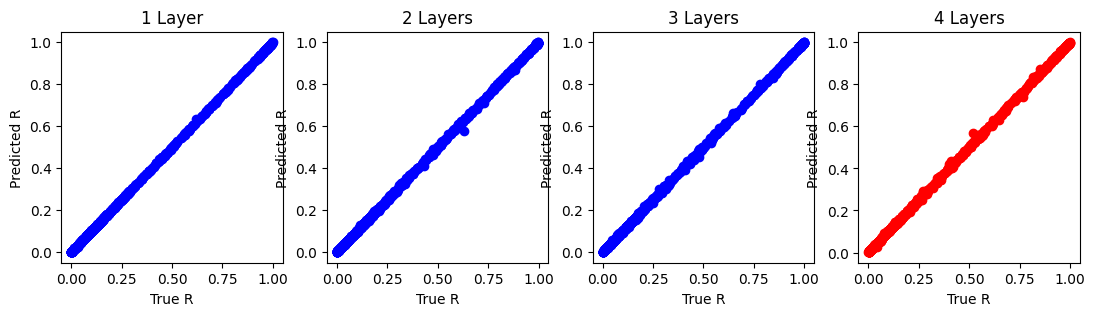

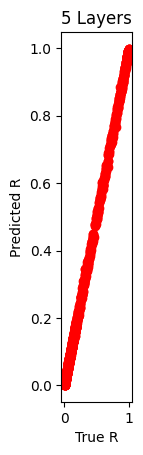

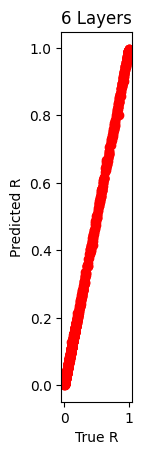

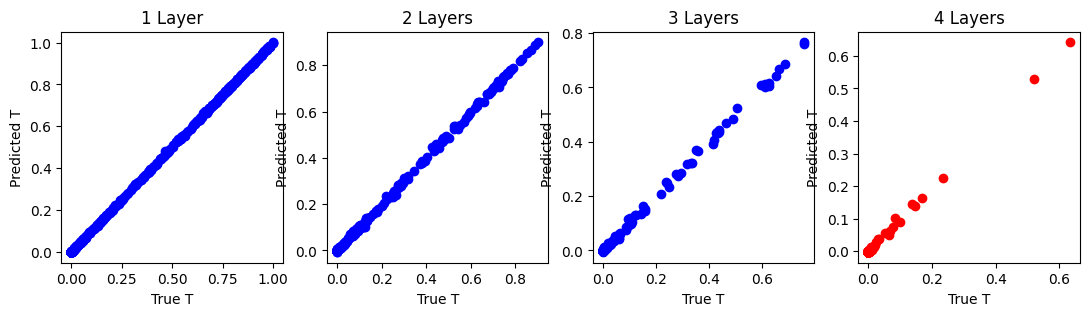

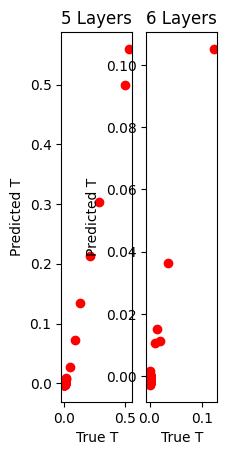

In [ ]:
output1, loss1 = test(rnn, input_tensor_1l_test, answer_tensor_1l_test, criterion, optimizer, batch_size_test, device)
output2, loss2 = test(rnn, input_tensor_2l_test, answer_tensor_2l_test, criterion, optimizer, batch_size_test, device)
output3, loss3 = test(rnn, input_tensor_3l_test, answer_tensor_3l_test, criterion, optimizer, batch_size_test, device)
output4, loss4 = test(rnn, input_tensor_4l_test, answer_tensor_4l_test, criterion, optimizer, batch_size_test, device)
output5, loss5 = test(rnn, input_tensor_5l_test, answer_tensor_5l_test, criterion, optimizer, batch_size_test, device)
start = time.time()
output6, loss6 = test(rnn, input_tensor_6l_test, answer_tensor_6l_test, criterion, optimizer, batch_size_test, device)
end = time.time()
print("Time:", end-start)
print(loss1, loss2, loss3, loss4, loss5, loss6)
output1 = output1.to('cpu').detach().numpy()
output2 = output2.to('cpu').detach().numpy()
output3 = output3.to('cpu').detach().numpy()
output4 = output4.to('cpu').detach().numpy()
output5 = output5.to('cpu').detach().numpy()
output6 = output6.to('cpu').detach().numpy()
answer1 = answer_tensor_1l_test.to('cpu').detach().numpy()
answer2 = answer_tensor_2l_test.to('cpu').detach().numpy()
answer3 = answer_tensor_3l_test.to('cpu').detach().numpy()
answer4 = answer_tensor_4l_test.to('cpu').detach().numpy()
answer5 = answer_tensor_5l_test.to('cpu').detach().numpy()
answer6 = answer_tensor_6l_test.to('cpu').detach().numpy()
np.savetxt('/content/drive/My Drive/Colab Notebooks/RNN_Monte_Carlo/output1_RNN.txt', output1)
np.savetxt('/content/drive/My Drive/Colab Notebooks/RNN_Monte_Carlo/output2_RNN.txt', output2)
np.savetxt('/content/drive/My Drive/Colab Notebooks/RNN_Monte_Carlo/output3_RNN.txt', output3)
np.savetxt('/content/drive/My Drive/Colab Notebooks/RNN_Monte_Carlo/output4_RNN.txt', output4)
np.savetxt('/content/drive/My Drive/Colab Notebooks/RNN_Monte_Carlo/output5_RNN.txt', output5)
np.savetxt('/content/drive/My Drive/Colab Notebooks/RNN_Monte_Carlo/output6_RNN.txt', output6)
np.savetxt('/content/drive/My Drive/Colab Notebooks/RNN_Monte_Carlo/answer1_RNN.txt', answer1)
np.savetxt('/content/drive/My Drive/Colab Notebooks/RNN_Monte_Carlo/answer2_RNN.txt', answer2)
np.savetxt('/content/drive/My Drive/Colab Notebooks/RNN_Monte_Carlo/answer3_RNN.txt', answer3)
np.savetxt('/content/drive/My Drive/Colab Notebooks/RNN_Monte_Carlo/answer4_RNN.txt', answer4)
np.savetxt('/content/drive/My Drive/Colab Notebooks/RNN_Monte_Carlo/answer5_RNN.txt', answer5)
np.savetxt('/content/drive/My Drive/Colab Notebooks/RNN_Monte_Carlo/answer6_RNN.txt', answer6)
plt.figure(figsize=(20,3))
plt.subplot(1, 6, 1)
plt.plot(answer1[:, 0], output1[:, 0], "bo")
plt.title("1 Layer")
plt.ylabel('Predicted R')
plt.xlabel('True R')
plt.subplot(1, 6, 2)
plt.plot(answer2[:, 0], output2[:, 0], "bo")
plt.title("2 Layers")
plt.ylabel('Predicted R')
plt.xlabel('True R')
plt.subplot(1, 6, 3)
plt.plot(answer3[:, 0], output3[:, 0], "bo")
plt.title("3 Layers")
plt.ylabel('Predicted R')
plt.xlabel('True R')
plt.subplot(1, 6, 4)
plt.plot(answer4[:, 0], output4[:, 0], "ro")
plt.title("4 Layers")
plt.ylabel('Predicted R')
plt.xlabel('True R')
plt.show()
plt.subplot(1, 6, 5)
plt.plot(answer5[:, 0], output5[:, 0], "ro")
plt.title("5 Layers")
plt.ylabel('Predicted R')
plt.xlabel('True R')
plt.show()
plt.subplot(1, 6, 6)
plt.plot(answer6[:, 0], output6[:, 0], "ro")
plt.title("6 Layers")
plt.ylabel('Predicted R')
plt.xlabel('True R')
plt.show()

plt.figure(figsize=(20,3))
plt.subplot(1, 6, 1)
plt.plot(answer1[:, 2], output1[:, 2], "bo")
plt.title("1 Layer")
plt.ylabel('Predicted T')
plt.xlabel('True T')
plt.subplot(1, 6, 2)
plt.plot(answer2[:, 2], output2[:, 2], "bo")
plt.title("2 Layers")
plt.ylabel('Predicted T')
plt.xlabel('True T')
plt.subplot(1, 6, 3)
plt.plot(answer3[:, 2], output3[:, 2], "bo")
plt.title("3 Layers")
plt.ylabel('Predicted T')
plt.xlabel('True T')
plt.subplot(1, 6, 4)
plt.plot(answer4[:, 2], output4[:, 2], "ro")
plt.title("4 Layers")
plt.ylabel('Predicted T')
plt.xlabel('True T')
plt.show()
plt.subplot(1, 6, 5)
plt.plot(answer5[:, 2], output5[:, 2], "ro")
plt.title("5 Layers")
plt.ylabel('Predicted T')
plt.xlabel('True T')
plt.subplot(1, 6, 6)
plt.plot(answer6[:, 2], output6[:, 2], "ro")
plt.title("6 Layers")
plt.ylabel('Predicted T')
plt.xlabel('True T')
plt.show()

Load and run saved RNN

In [ ]:
np.random.seed(128)
torch.manual_seed(128)
input_dim = 4
# hyperparameters to tune
hidden_layer = 1024
hidden_layer2 = 1024
hidden_size = 16
# output is R, A, T
output_size = 3
batch_size = 585
batch_size_test = 1000
num_batches = int(18720/batch_size)
epochs = 1000

rnn = RNN(input_dim, hidden_layer, hidden_layer2, hidden_size, output_size)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Training on: " + str(device))
rnn = rnn.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.0001)
current_loss_train = 0
current_loss_test = 0
loss_plot_test = np.zeros(epochs)
loss_plot_train = np.zeros(epochs*num_batches)
x_axis = np.linspace(0, epochs, num=epochs*num_batches)


state_dict = torch.load('/content/drive/My Drive/Colab Notebooks/RNN_Monte_Carlo/rnn_1.6.pth')

rnn.load_state_dict(state_dict)


output1, loss1 = test(rnn, input_tensor_1l_test, answer_tensor_1l_test, criterion, optimizer, batch_size_test, device)
output2, loss2 = test(rnn, input_tensor_2l_test, answer_tensor_2l_test, criterion, optimizer, batch_size_test, device)
output3, loss3 = test(rnn, input_tensor_3l_test, answer_tensor_3l_test, criterion, optimizer, batch_size_test, device)
output4, loss4 = test(rnn, input_tensor_4l_test, answer_tensor_4l_test, criterion, optimizer, batch_size_test, device)
output5, loss5 = test(rnn, input_tensor_5l_test, answer_tensor_5l_test, criterion, optimizer, batch_size_test, device)
output6, loss6 = test(rnn, input_tensor_6l_test, answer_tensor_6l_test, criterion, optimizer, batch_size_test, device)
print(loss1, loss2, loss3, loss4, loss5, loss6)
output1 = output1.to('cpu').detach().numpy()
output2 = output2.to('cpu').detach().numpy()
output3 = output3.to('cpu').detach().numpy()
output4 = output4.to('cpu').detach().numpy()
output5 = output5.to('cpu').detach().numpy()
output6 = output6.to('cpu').detach().numpy()
answer1 = answer_tensor_1l_test.to('cpu').detach().numpy()
answer2 = answer_tensor_2l_test.to('cpu').detach().numpy()
answer3 = answer_tensor_3l_test.to('cpu').detach().numpy()
answer4 = answer_tensor_4l_test.to('cpu').detach().numpy()
answer5 = answer_tensor_5l_test.to('cpu').detach().numpy()
answer6 = answer_tensor_6l_test.to('cpu').detach().numpy()
#np.savetxt('/content/drive/My Drive/Colab Notebooks/RNN_Monte_Carlo/output1_RNN.txt', output1)
#np.savetxt('/content/drive/My Drive/Colab Notebooks/RNN_Monte_Carlo/output2_RNN.txt', output2)
#np.savetxt('/content/drive/My Drive/Colab Notebooks/RNN_Monte_Carlo/output3_RNN.txt', output3)
#np.savetxt('/content/drive/My Drive/Colab Notebooks/RNN_Monte_Carlo/output4_RNN.txt', output4)
#np.savetxt('/content/drive/My Drive/Colab Notebooks/RNN_Monte_Carlo/output5_RNN.txt', output5)
#np.savetxt('/content/drive/My Drive/Colab Notebooks/RNN_Monte_Carlo/output6_RNN.txt', output6)
#np.savetxt('/content/drive/My Drive/Colab Notebooks/RNN_Monte_Carlo/answer1_RNN.txt', answer1)
#np.savetxt('/content/drive/My Drive/Colab Notebooks/RNN_Monte_Carlo/answer2_RNN.txt', answer2)
#np.savetxt('/content/drive/My Drive/Colab Notebooks/RNN_Monte_Carlo/answer3_RNN.txt', answer3)
#np.savetxt('/content/drive/My Drive/Colab Notebooks/RNN_Monte_Carlo/answer4_RNN.txt', answer4)
#np.savetxt('/content/drive/My Drive/Colab Notebooks/RNN_Monte_Carlo/answer5_RNN.txt', answer5)
#np.savetxt('/content/drive/My Drive/Colab Notebooks/RNN_Monte_Carlo/answer6_RNN.txt', answer6)

Training on: cuda
3.167288923577871e-06 1.342157611361472e-05 1.3006816516281106e-05 9.957088877854403e-06 1.8602457203087397e-05 1.6610361853963695e-05


Save weights and biases to numpy array

In [ ]:
np.random.seed(128)
torch.manual_seed(128)
input_dim = 4
# hyperparameters to tune
hidden_layer = 1024
hidden_layer2 = 1024
hidden_size = 16
# output is R, A, T
output_size = 3
batch_size = 585
batch_size_test = 1000
num_batches = int(18720/batch_size)
epochs = 1000
state_dict = torch.load('/content/drive/My Drive/Colab Notebooks/RNN_Monte_Carlo/rnn_1.6.pth')
rnn = RNN(input_dim, hidden_layer, hidden_layer2, hidden_size, output_size)
rnn.load_state_dict(state_dict)

w1 = rnn.i2l1.weight.cpu().detach().numpy()
w2 = rnn.l1l2.weight.cpu().detach().numpy()
w3 = rnn.l2l3.weight.cpu().detach().numpy()
w_output = rnn.m2o.weight.cpu().detach().numpy()
w_hidden = rnn.m2h.weight.cpu().detach().numpy()
b1 = rnn.i2l1.bias.cpu().detach().numpy()
b2 = rnn.l1l2.bias.cpu().detach().numpy()
b3 = rnn.l2l3.bias.cpu().detach().numpy()
b_output = rnn.m2o.bias.cpu().detach().numpy()
b_hidden = rnn.m2h.bias.cpu().detach().numpy()
print(w_hidden.shape)

np.savetxt('/content/drive/My Drive/Colab Notebooks/RNN_Monte_Carlo/w1_rnn1.6.txt', w1)
np.savetxt('/content/drive/My Drive/Colab Notebooks/RNN_Monte_Carlo/w2_rnn1.6.txt', w2)
np.savetxt('/content/drive/My Drive/Colab Notebooks/RNN_Monte_Carlo/w3_rnn1.6.txt', w3)
np.savetxt('/content/drive/My Drive/Colab Notebooks/RNN_Monte_Carlo/wo_rnn1.6.txt', w_output)
np.savetxt('/content/drive/My Drive/Colab Notebooks/RNN_Monte_Carlo/wh_rnn1.6.txt', w_hidden)
np.savetxt('/content/drive/My Drive/Colab Notebooks/RNN_Monte_Carlo/b1_rnn1.6.txt', b1)
np.savetxt('/content/drive/My Drive/Colab Notebooks/RNN_Monte_Carlo/b2_rnn1.6.txt', b2)
np.savetxt('/content/drive/My Drive/Colab Notebooks/RNN_Monte_Carlo/b3_rnn1.6.txt', b3)
np.savetxt('/content/drive/My Drive/Colab Notebooks/RNN_Monte_Carlo/bo_rnn1.6.txt', b_output)
np.savetxt('/content/drive/My Drive/Colab Notebooks/RNN_Monte_Carlo/bh_rnn1.6.txt', b_hidden)

<ipython-input-14-1e65517117c7>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('/content/drive/My Drive/Colab Notebooks/RNN_Monte_Carlo/rnn_1.6.pt

(16, 1024)
